In [1]:
import pandas as pd
import numpy as np

# Read Data

In [2]:
df = pd.read_excel("/home/sheetal/Downloads/Delhi.xlsx", parse_dates=[0],skiprows=2)
## reading a xlsx file using pandas library
df['pm25']=pd.to_numeric(df['pm25'],errors='coerce')
df.sort_values(by=['date'],ascending=True,inplace=True)
rolling_airquality=df['pm25'].fillna(df.pm25.rolling(36,min_periods=1).mean(),inplace=True)

df[538:]

,date,pm25
1835,2018-01-23 10:00:00,321.000000
1834,2018-01-23 11:00:00,305.000000
1833,2018-01-23 12:00:00,300.000000
1832,2018-01-26 15:00:00,306.685714
1831,2018-01-26 16:00:00,306.058824
...,...,...
4,2018-04-19 20:00:00,57.000000
3,2018-04-19 21:00:00,57.000000
2,2018-04-19 22:00:00,75.000000
1,2018-04-19 23:00:00,89.000000


In [3]:
df.to_csv("Delhi_eda.csv")

# Check For Stationarity

In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [4]:
adf_test(df)

1. ADF :  -3.480907985025991
2. P-Value :  0.008491170927087819
3. Num Of Lags :  27
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 2346
5. Critical Values :
	 1% :  -3.433140481496303
	 5% :  -2.862772784334684
	 10% :  -2.567426264858143



# figure Out Order for ARIMA Model

In [5]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
from statsmodels.tsa.arima_model import ARIMA

# Split Data into Training and Testing

In [7]:
print(df.shape)
train=df.iloc[:-300]
test=df.iloc[-300:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(2374, 1)
(2074, 1) (300, 1)
pm25    185.0
Name: 2018-04-04 23:00:00, dtype: float64 pm25    92.0
Name: 2018-04-20 00:00:00, dtype: float64


# Train the Model

In [8]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train,order=(6,1,6))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.pm25   No. Observations:                 2073
Model:                 ARIMA(6, 1, 6)   Log Likelihood              -11048.905
Method:                       css-mle   S.D. of innovations             49.907
Date:                Sun, 02 May 2021   AIC                          22125.811
Time:                        13:11:19   BIC                          22204.725
Sample:                             1   HQIC                         22154.734
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1201      0.136     -0.880      0.379      -0.388       0.147
ar.L1.D.pm25     2.2285      0.174     12.818      0.000       1.888       2.569
ar.L2.D.pm25    -1.4434      0.455     -3.173      0.002      -2.335      -0.552
ar.L3.D.pm25    -0.1544      0.876     -0.176      0.860      -1.872       1.563
ar.L4.D.pm25     0.6373      1.033      0.617      0.537      -1.388       2.663
ar.L5.D.pm25    -0.4345      0.632     -0.688      0.492      -1.673       0.804
ar.L6.D.pm25     0.1233      0.172      0.715      0.475      -0.215       0.461
ma.L1.D.pm25    -2.2712      0.172    -13.220      0.000      -2.608      -1.934
ma.L2.D.pm25     1.3182      0.458      2.876      0.004       0.420       2.217
ma.L3.D.pm25     0.3219      0.884      0.364      0.716      -1.410       2.054
ma.L4.D.pm25    -0.5396      1.003     -0.538      0.591      -2.506       1.427
ma.L5.D.pm25     0.3397      0.569      0.597      0.551      -0.776       1.456
ma.L6.D.pm25    -0.1638      0.159     -1.033      0.302      -0.475       0.147
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4528           -0.0000j            1.4528           -0.5000
AR.2            0.9694           -0.2608j            1.0039           -0.0418
AR.3            0.9694           +0.2608j            1.0039            0.0418
AR.4            0.6620           -1.6711j            1.7975           -0.1900
AR.5            0.6620           +1.6711j            1.7975            0.1900
AR.6            1.7148           -0.0000j            1.7148           -0.0000
MA.1           -1.4499           -0.0000j            1.4499           -0.5000
MA.2            0.9980           -0.2588j            1.0310           -0.0404
MA.3            0.9980           +0.2588j            1.0310            0.0404
MA.4            1.0462           -0.0000j            1.0462           -0.0000
MA.5            0.2410           -1.9311j            1.9460           -0.2302
MA.6            0.2410           +1.9311j            1.9460            0.2302
-----------------------------------------------------------------------------
"""

In [9]:
start=len(train)
end=len(train)+len(test)-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
#index_future_dates=pd.date_range(start='2018-12-01',end='2018-12-30')
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred.index=df.index[start:end+1]
print(pred)

date
2018-04-04 23:00:00    216.761919
2018-04-05 00:00:00    205.973978
2018-04-05 01:00:00    201.907515
2018-04-05 02:00:00    200.868951
2018-04-05 03:00:00    198.616765
                          ...    
2018-04-19 20:00:00    119.090737
2018-04-19 21:00:00    115.107092
2018-04-19 22:00:00    111.075325
2018-04-19 23:00:00    107.263474
2018-04-20 00:00:00    103.922473
Name: ARIMA predictions, Length: 300, dtype: float64


<AxesSubplot:xlabel='date'>

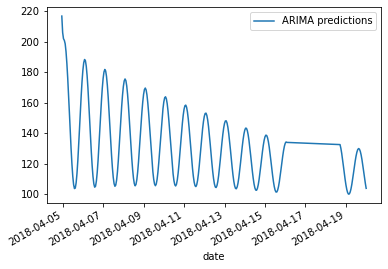

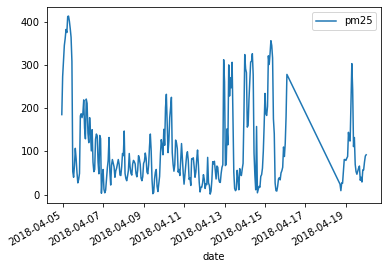

In [10]:
pred.plot(legend=True)
test.plot(legend=True)

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test))
print(rmse)

93.8934829563791


In [12]:
model2=ARIMA(df,order=(6,1,6))
model2=model2.fit()

In [13]:
df.tail()

,pm25
date,
2018-04-19 20:00:00,57.0
2018-04-19 21:00:00,57.0
2018-04-19 22:00:00,75.0
2018-04-19 23:00:00,89.0
2018-04-20 00:00:00,92.0


In [14]:
index_future_dates=pd.date_range(start='2018-04-20 00:00:00',periods=25,freq='H')
pred=model2.predict(start=len(df),end=len(df)+24,typ='levels').rename('ARIMA Predictions')
pred.index=index_future_dates
print(pred)

2018-04-20 00:00:00     97.514121
2018-04-20 01:00:00    101.070350
2018-04-20 02:00:00    103.025355
2018-04-20 03:00:00    103.175960
2018-04-20 04:00:00    101.654968
2018-04-20 05:00:00     98.998731
2018-04-20 06:00:00     95.707996
2018-04-20 07:00:00     92.122632
2018-04-20 08:00:00     88.474619
2018-04-20 09:00:00     85.007884
2018-04-20 10:00:00     81.977664
2018-04-20 11:00:00     79.613148
2018-04-20 12:00:00     78.075904
2018-04-20 13:00:00     77.456367
2018-04-20 14:00:00     77.777652
2018-04-20 15:00:00     79.001685
2018-04-20 16:00:00     81.029923
2018-04-20 17:00:00     83.708920
2018-04-20 18:00:00     86.840457
2018-04-20 19:00:00     90.196852
2018-04-20 20:00:00     93.537349
2018-04-20 21:00:00     96.624916
2018-04-20 22:00:00     99.242095
2018-04-20 23:00:00    101.205639
2018-04-21 00:00:00    102.378733
Freq: H, Name: ARIMA Predictions, dtype: float64


In [ ]:
pip freeze

In [27]:
df[540:]

,pm25
date,
2018-01-23 12:00:00,300.000000
2018-01-26 15:00:00,306.685714
2018-01-26 16:00:00,306.058824
2018-01-26 17:00:00,305.030303
2018-01-26 18:00:00,304.656250
...,...
2018-04-19 20:00:00,57.000000
2018-04-19 21:00:00,57.000000
2018-04-19 22:00:00,75.000000


In [ ]:
data1=23

In [ ]:
import pickle 

In [ ]:
pickle.dump(model2,open('model.p','wb')) 